# Testing ML-models and molecular representations for MIC prediction of benzimidazole hybrids
In order to decide wether newly generated molecule is bioactive or not it is necessary to obtain its minimal inhibitory concentration (MIC). To adress this problem we are going to create a model which takes molecular structure as input and predicts its MIC value. By testing different ML methods and molecular representations we want to obtain the best result in terms of accuracy, time and interpretability.

## Dependencies

In [ ]:
%pip install rdkit -q
%pip install lazypredict -q
%pip install git+https://github.com/samoturk/mol2vec -q
%pip install optuna -q
%pip install scikit-learn==1.2.2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 66.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import optuna

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import rdDepictor, AllChem, rdRGroupDecomposition, PandasTools
from IPython.display import SVG
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

import lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from mol2vec import features
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

from xgboost import XGBRegressor
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Prepare data

In [ ]:
# upload dataset
df = pd.read_csv('ecoli_qsar.csv')
df.head()

,smiles,doi,id,group,group_name,MIC,lgMIC,scaffold
0,O=C(OCC)C1=C(NC(=O)NC1C=2OC=CC2)CN3C=NC=4C=CC=...,10.1002/cjoc.202200326,5a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.17,-0.76,O=C1NC(Cn2cnc3ccccc32)=CC(c2ccco2)N1
1,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,5b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.08,-1.08,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1
2,O=C(OCC)C1=C(N(C(=O)N(C1C2=C(C=CS2)C)[H])[H])C...,10.1002/cjoc.202200326,5c,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.08,-1.09,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1
3,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.03,-1.46,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1
4,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.04,-1.43,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1


In [ ]:
df.shape

(419, 8)

In [ ]:
df.drop_duplicates(subset=['smiles','MIC'], inplace=True)
df.shape

(392, 8)

In [ ]:
repeated_smiles = df[df.smiles.duplicated()].smiles.unique()
len(repeated_smiles)

66

In [ ]:
# filling with the median
for smi in repeated_smiles:
  df_temp = df[df.smiles==smi]
  df.loc[df.smiles==smi, 'MIC'] = df_temp.MIC.median()

In [ ]:
df.drop_duplicates(subset=['smiles', 'MIC'], inplace=True)
df.shape

(326, 8)

<Axes: >

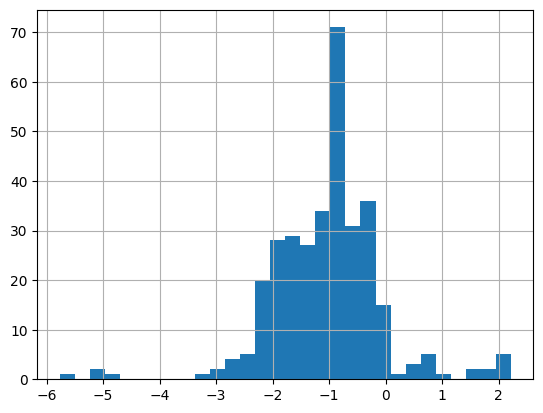

In [ ]:
df.lgMIC = df.MIC.apply(lambda x: np.log10(x))
df.lgMIC.hist(bins=30)

In [ ]:
df_ecoli = df.copy()

In [ ]:
# all groups that are less than 2 in the dataset are labeled as other
majority_groups = pd.DataFrame({'group':df_ecoli.group.value_counts().keys(), 'count': df_ecoli.group.value_counts().values})
majority_groups = majority_groups[majority_groups['count']>1].group.tolist()
df_ecoli['group_strat'] =  df_ecoli.group.apply(lambda x: x if x in majority_groups else 'other')

In [ ]:
df_ecoli.to_csv('ecoli_qsar.csv', index=False)

## Morgan fingerprints (regression)

In [ ]:
def get_fingerprint(smiles):
  '''Converts SMILES into Morgan fingerprint'''
  fp_array = np.zeros((0,), dtype=np.int8)
  mol = Chem.MolFromSmiles(smiles)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
  ConvertToNumpyArray(fp, fp_array)
  return fp_array

In [ ]:
# create fingerprints from SMILES
df_ecoli['fp'] = df_ecoli['smiles'].apply(get_fingerprint)

In [ ]:
# split data into predictor and target
X = np.stack(df_ecoli.fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y = df_ecoli['lgMIC']#.apply(lambda x: -x)

In [ ]:
X_train, X_test, y_train, y_test, indicies_train, indicies_test = train_test_split(X, y, df_ecoli.index, test_size=0.2, random_state=42, stratify=df_ecoli.group_strat)

In [ ]:
for idx in df_ecoli.index:
  if idx in indicies_test:
    df_ecoli.loc[idx, 'subset'] = 'test'
  else:
    df_ecoli.loc[idx, 'subset'] = 'train'

In [ ]:
df_ecoli.subset.value_counts()

,count
subset,
train,260
test,66


(array([  2.,   1.,   0.,   5.,  45.,  72., 107.,  16.,   5.,   7.]),
 array([-5.7636376 , -4.96600183, -4.16836605, -3.37073028, -2.5730945 ,
        -1.77545872, -0.97782295, -0.18018717,  0.6174486 ,  1.41508438,
         2.21272015]),
 <BarContainer object of 10 artists>)

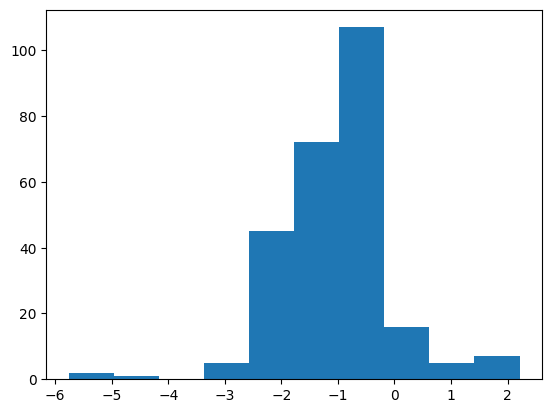

In [ ]:
plt.hist(y_train)

(array([ 1.,  0.,  2.,  3., 13., 23., 18.,  3.,  1.,  2.]),
 array([-5.15947846, -4.42595045, -3.69242244, -2.95889443, -2.22536642,
        -1.49183841, -0.7583104 , -0.0247824 ,  0.70874561,  1.44227362,
         2.17580163]),
 <BarContainer object of 10 artists>)

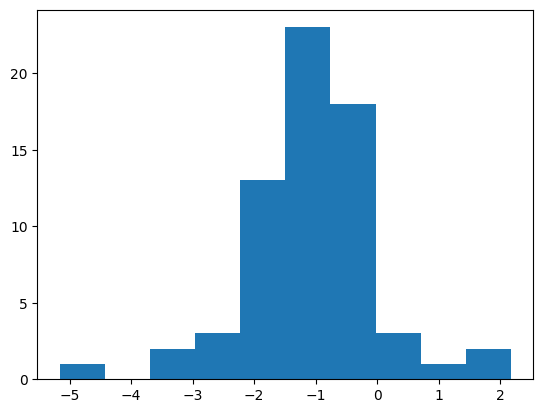

In [ ]:
plt.hist(y_test)

In [ ]:
# obtain model results with Lazy Predict
reg = LazyRegressor(verbose=-1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
models.tail(10)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLarsCV,1.08,0.75,0.53,1.79
LassoCV,1.08,0.75,0.53,5.58
HistGradientBoostingRegressor,1.08,0.75,0.52,0.52
ElasticNetCV,1.08,0.76,0.52,3.60
LGBMRegressor,1.08,0.76,0.52,0.11
OrthogonalMatchingPursuit,1.08,0.76,0.52,0.03
BayesianRidge,1.08,0.76,0.51,0.06
RandomForestRegressor,1.07,0.78,0.49,0.68
GradientBoostingRegressor,1.07,0.79,0.49,0.28


### XGB

In [ ]:
def grid_search_and_test(exp_name, param_grid, estimator, X_train, y_train, X_test, y_test):

  print('Performing grid_search...')
  search = GridSearchCV(estimator=estimator,
                      param_grid=param_grid,
                      scoring=['neg_mean_squared_error','r2'],
                      refit='neg_mean_squared_error',
                      n_jobs=1,
                      cv=KFold(n_splits=5, shuffle=True, random_state=42))
  search.fit(X_train, y_train)
  results = pd.DataFrame(search.cv_results_)
  results.to_csv(f'{exp_name}.csv')
  best_results = results[results.rank_test_neg_mean_squared_error==1]

  print('Testing the best model...')
  print('Best params:', search.best_params_)
  model = search.best_estimator_
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print(f'R2 cross val: {best_results.mean_test_r2.tolist()[0]} +- {best_results.std_test_r2.tolist()[0]}')
  print(f'RMSE cross val: {best_results.mean_test_neg_mean_squared_error.tolist()[0]} +- {best_results.std_test_neg_mean_squared_error.tolist()[0]}')
  print('R2 train:', r2_score(y_train, y_train_pred))
  print('RMSE train:', mean_squared_error(y_train, y_train_pred))
  print('R2 test:', r2_score(y_test, y_test_pred))
  print('RMSE test:', mean_squared_error(y_test, y_test_pred))

In [ ]:
param_grid = {
        'n_estimators':[100, 200, 300, 400, 500],
        'learning_rate':[.001,0.01,.1],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [.5,.75,1],
        'max_depth': [1,2,4]
        }

grid_search_and_test('MFP_XGB', param_grid, XGBRegressor(random_state=42), X_train, y_train, X_test, y_test)

Performing grid_search...
Testing the best model...
Best params: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 400, 'random_state': 42, 'subsample': 0.5}
R2 cross val: 0.6337263573581524 +- 0.14529517183612606
RMSE cross val: -0.31151167824021414 +- 0.08914452659066674
R2 train: 0.8400416115343451
RMSE train: 0.14758379572252775
R2 test: 0.779521367114267
RMSE test: 0.24605981215995754



### GradientBoosting

In [ ]:
param_grid = {'n_estimators':[100, 200, 300, 400, 500],
               'learning_rate':[.001,0.01,.1],
               'max_depth':[1, 2, 4],
               'subsample':[.5,.75,1]}

grid_search_and_test('MFP_GB', param_grid, GradientBoostingRegressor(random_state=42), X_train, y_train, X_test, y_test)

Performing grid_search...
Testing the best model...
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.5}
R2 cross val: 0.5974365222262252 +- 0.22842312216570168
RMSE cross val: -0.3337979599643627 +- 0.13633672838252084
R2 train: 0.8545047797181212
RMSE train: 0.1342395173810809
R2 test: 0.809909092800011
RMSE test: 0.21214633049356105


In [ ]:
params = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.5}
model = GradientBoostingRegressor(random_state=42, **params)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('R2 train:', r2_score(y_train, y_train_pred))
print('RMSE train:', mean_squared_error(y_train, y_train_pred))
print('R2 test:', r2_score(y_test, y_test_pred))
print('RMSE test:', mean_squared_error(y_test, y_test_pred))

R2 train: 0.8545047797181212
RMSE train: 0.1342395173810809
R2 test: 0.809909092800011
RMSE test: 0.21214633049356105


In [ ]:
import pickle
pickle.dump(model, open('benz_model_gb.pkl', 'wb'))

#### Plot

In [ ]:
y_pred = np.concatenate((y_test_pred, y_train_pred), axis=None)
y_true = np.concatenate((y_test.to_numpy(), y_train.to_numpy()), axis=None)

In [ ]:
plot_df = pd.DataFrame()
plot_df['y_true'] = y_true[::-1]
plot_df['y_pred'] = y_pred[::-1]
subset = ['test' for i in range(len(y_test))]+['train' for i in range(len(y_train))]
plot_df['subset'] = subset[::-1]
plot_df.head()

,y_true,y_pred,subset
0,-0.35,-1.12,train
1,-1.19,-1.28,train
2,-0.88,-1.51,train
3,-1.25,-0.95,train
4,-2.28,-2.27,train


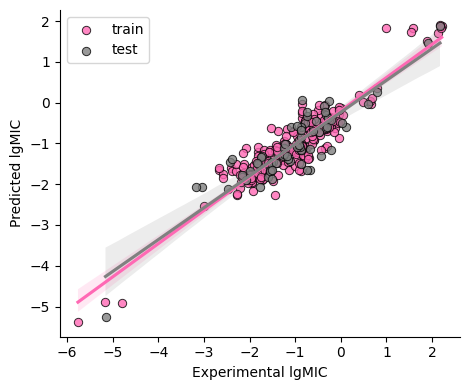

In [ ]:
import seaborn as sns

ax = sns.lmplot(x = "y_true", y = "y_pred",
           hue = "subset", data = plot_df, scatter_kws={'linewidths':0.7,'edgecolor':'black'}, legend=False,
                palette=['hotpink', 'gray'], height=4, aspect=1.2)
ax.set(xlabel='Experimental lgMIC', ylabel='Predicted lgMIC')
plt.legend(loc='upper left')
plt.savefig('regression.png', dpi=500)

#### Metrics for outliers

In [ ]:
df_ecoli.reset_index(drop=True, inplace=True)

# detach the dataset without outliers
Q1 = df_ecoli['lgMIC'].quantile(0.25)
Q3 = df_ecoli['lgMIC'].quantile(0.75)
IQR = Q3 - Q1

filter = (df_ecoli['lgMIC'] >= Q1 - 1.5 * IQR) & (df_ecoli['lgMIC'] <= Q3 + 1.5 *IQR)
data = df_ecoli.loc[filter]
len(data.index)

311

<Axes: >

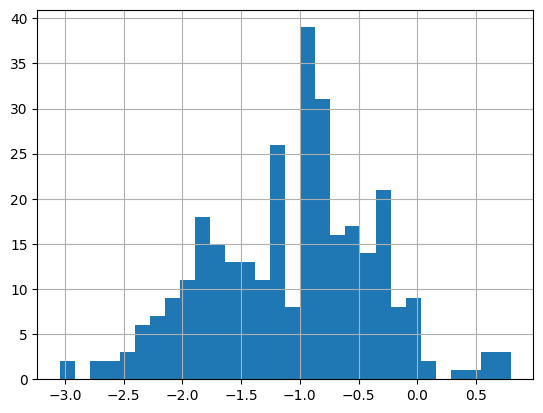

In [ ]:
data.lgMIC.hist(bins=30)

In [ ]:
df_ecoli.shape

(326, 13)

In [ ]:
data1 = df_ecoli[df_ecoli.smiles.isin(data.smiles.tolist())==False]
data1.shape

(15, 13)

In [ ]:
X_train_outliers = np.stack(data1[data1.subset=='train'].fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y_train_outliers = data1[data1.subset=='train']['lgMIC']

X_test_outliers = np.stack(data1[data1.subset=='test'].fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y_test_outliers = data1[data1.subset=='test']['lgMIC']

y_outliers_train_pred = model.predict(X_train_outliers)
y_outliers_test_pred = model.predict(X_test_outliers)

print('R2 train outliers:', r2_score(y_train_outliers, y_outliers_train_pred))
print('RMSE train outliers:', mean_squared_error(y_train_outliers, y_outliers_train_pred))
print('R2 test outliers:', r2_score(y_test_outliers, y_outliers_test_pred))
print('RMSE test outliers:', mean_squared_error(y_test_outliers, y_outliers_test_pred))

R2 train outliers: 0.9849432134815613
RMSE train outliers: 0.15238077326740793
R2 test outliers: 0.9623688223007789
RMSE test outliers: 0.381276186494225


### Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
}

grid_search_and_test('MFP_RF', param_grid, RandomForestRegressor(random_state=42), X_train, y_train, X_test, y_test)

Performing grid_search...
Testing the best model...
Best params: {'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 200}
R2 cross val: 0.5852449282181824 +- 0.14495717624667612
RMSE cross val: -0.349469802955881 +- 0.05916997773090669
R2 train: 0.7234751770399538
RMSE train: 0.2551324964911493
R2 test: 0.6772190661246107
RMSE test: 0.36023180531673815


### Extra Trees

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
}

grid_search_and_test('MFP_ET', param_grid, ExtraTreesRegressor(random_state=42), X_train, y_train, X_test, y_test)

Performing grid_search...
Testing the best model...
Best params: {'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 500}
R2 cross val: 0.5956874814005297 +- 0.16014779246840916
RMSE cross val: -0.33524302119014193 +- 0.06396792041045248
R2 train: 0.719345710135274
RMSE train: 0.2589425023679843
R2 test: 0.6729677814765854
RMSE test: 0.3649763480791825


### LGBM

In [ ]:
param_grid = {
        'n_estimators':[100, 200, 300, 400, 500],
        'learning_rate':[.001,0.01,.1],
        'subsample': [.5,.75,1],
        'max_depth': [1,2,4]
        }

grid_search_and_test('MFP_LGBM', param_grid, lgb.LGBMRegressor(random_state=42, verbose=-1), X_train, y_train, X_test, y_test)

Performing grid_search...
Testing the best model...
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.5}
R2 cross val: 0.6339966419043477 +- 0.16836309386558324
RMSE cross val: -0.30137806560538294 +- 0.0820270799017129
R2 train: 0.8770675245117573
RMSE train: 0.113422256401495
R2 test: 0.7480757125891531
RMSE test: 0.28115396955935756


In [ ]:
import pickle
params = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.5}
model = lgb.LGBMRegressor(random_state=42, verbose=-1, **params)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
pickle.dump(model, open('benz_model_lgbm.pkl', 'wb'))

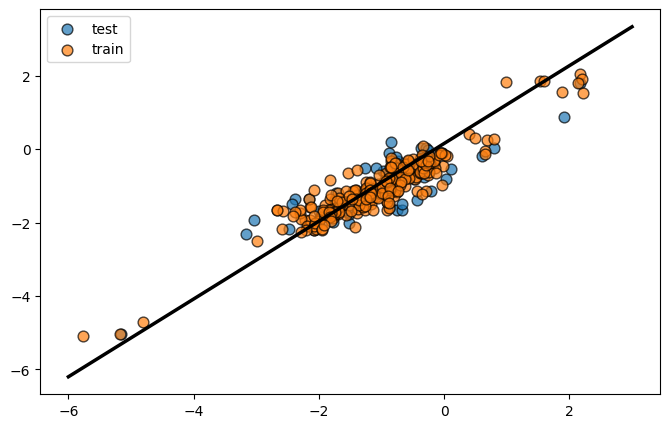

In [ ]:
# Initialize layout
fig, ax = plt.subplots(figsize=(8, 5))

# Add scatterplot
ax.scatter(y_test, y_test_pred, s=60, alpha=0.7, edgecolors="k", label='test')

ax.scatter(y_train, y_train_pred, s=60, alpha=0.7, edgecolors="k", label='train')

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
rng = np.random.default_rng(1234)
x = rng.uniform(-6, 3, size=100)
y = x + rng.normal(size=100)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(-6, 3, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)
ax.legend()

## Mol2Vec (regression)

In [ ]:
# load a pre-trained Mol2vec model
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [ ]:
# generate mols
mols = [Chem.MolFromSmiles(smi) for smi in df_ecoli['smiles']]

In [ ]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [ ]:
# generate molecular sentences
df_ecoli['sentence'] = [mol2alt_sentence(m, 1) for m in mols]
df_ecoli['mol2vec'] = [DfVec(x) for x in sentences2vec(df_ecoli['sentence'], model, unseen='UNK')]

In [ ]:
# prepare data
X_vec = np.array([x.vec for x in df_ecoli['mol2vec']])
y_vec = np.array(df_ecoli['lgMIC'])

In [ ]:
X_vec.shape

(326, 300)

In [ ]:
# split data into train and test
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X_vec, y_vec, test_size=0.2, random_state=42, stratify=df_ecoli.group_strat)

In [ ]:
# obtain model results with Lazy Predict
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train_vec, X_test_vec, y_train_vec, y_test_vec)

In [ ]:
models.tail(10)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
BayesianRidge,1.08,0.72,0.56,0.26
RidgeCV,1.08,0.72,0.56,0.18
LinearRegression,1.07,0.74,0.54,0.12
TransformedTargetRegressor,1.07,0.74,0.54,0.08
MLPRegressor,1.07,0.74,0.54,0.49
RandomForestRegressor,1.07,0.75,0.53,3.76
AdaBoostRegressor,1.07,0.75,0.52,1.16
XGBRegressor,1.07,0.76,0.51,6.83
GradientBoostingRegressor,1.06,0.77,0.51,2.78


### GradientBoosting

In [ ]:
param_grid = {'n_estimators':[100, 200, 300, 400, 500],
               'learning_rate':[.001,0.01,.1],
               'max_depth':[1, 2, 4],
               'subsample':[.5,.75,1]}

grid_search_and_test('MV_GB', param_grid, GradientBoostingRegressor(random_state=42), X_train_vec, y_train_vec, X_test_vec, y_test_vec)

Performing grid_search...
Testing the best model...
Best params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.75}
R2 cross val: 0.6211228854166047 +- 0.13999804775983213
RMSE cross val: -0.3178999565174262 +- 0.05810619768275543
R2 train: 0.889925395334607
RMSE train: 0.10155908749145352
R2 test: 0.7438923034776228
RMSE test: 0.28582276148127084


### Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
}

grid_search_and_test('MV_RF', param_grid, RandomForestRegressor(random_state=42), X_train_vec, y_train_vec, X_test_vec, y_test_vec)

Performing grid_search...
Testing the best model...
Best params: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 500}
R2 cross val: 0.5545598411979863 +- 0.16124680155504634
RMSE cross val: -0.37824703606652754 +- 0.07985518576054437
R2 train: 0.8101338315827791
RMSE train: 0.17517787021418185
R2 test: 0.7267200591353815
RMSE test: 0.30498742683642427


### Extra Trees

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
}

grid_search_and_test('MV_ET', param_grid, ExtraTreesRegressor(random_state=42), X_train_vec, y_train_vec, X_test_vec, y_test_vec)

Performing grid_search...
Testing the best model...
Best params: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 200}
R2 cross val: 0.6117912689712254 +- 0.17110320487207054
RMSE cross val: -0.3200406153949682 +- 0.07952460163625735
R2 train: 0.7643517475512016
RMSE train: 0.21741819160200745
R2 test: 0.7221453712065089
RMSE test: 0.3100928959593764


### XGB

In [ ]:
param_grid = {
        'n_estimators':[100, 200, 300, 400, 500],
        'learning_rate':[.001,0.01,.1],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [.5,.75,1],
        'max_depth': [1,2,4]
        }

grid_search_and_test('MV_XGB', param_grid, XGBRegressor(random_state=42), X_train_vec, y_train_vec, X_test_vec, y_test_vec)

Performing grid_search...
Testing the best model...
Best params: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 400, 'subsample': 0.75}
R2 cross val: 0.6200650491182005 +- 0.14264896032909036
RMSE cross val: -0.3185625754226238 +- 0.06188216362773423
R2 train: 0.9256073813835661
RMSE train: 0.0686375071321067
R2 test: 0.7759699491110035
RMSE test: 0.2500232857870705


In [ ]:
results = pd.read_csv('MV_XGB.csv')

In [ ]:
n=4
best_results = results[results.rank_test_neg_mean_squared_error==n]
results[results.rank_test_neg_mean_squared_error==n].params.tolist()[0]

"{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.75}"

In [ ]:
params = {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.75}
model = XGBRegressor(random_state=42, **params)
model.fit(X_train_vec, y_train_vec)

y_train_pred = model.predict(X_train_vec)
y_test_pred = model.predict(X_test_vec)

print(f'R2 cross val: {best_results.mean_test_r2.tolist()[0]} +- {best_results.std_test_r2.tolist()[0]}')
print(f'RMSE cross val: {best_results.mean_test_neg_mean_squared_error.tolist()[0]} +- {best_results.std_test_neg_mean_squared_error.tolist()[0]}')
print('R2 train:', r2_score(y_train_vec, y_train_pred))
print('RMSE train:', mean_squared_error(y_train_vec, y_train_pred))
print('R2 test:', r2_score(y_test_vec, y_test_pred))
print('RMSE test:', mean_squared_error(y_test_vec, y_test_pred))

R2 cross val: 0.6163038265833687 +- 0.1452585922340869
RMSE cross val: -0.3222367033469319 +- 0.0657476659535847
R2 train: 0.8804355296366411
RMSE train: 0.1103148046128694
R2 test: 0.7748550663139944
RMSE test: 0.2512675235983354


### LGBM

In [ ]:
param_grid = {
        'n_estimators':[100, 200, 300, 400, 500],
        'learning_rate':[.001,0.01,.1],
        'subsample': [.5,.75,1],
        'max_depth': [1,2,4]
        }

grid_search_and_test('MV_LGBM', param_grid, lgb.LGBMRegressor(random_state=42, verbose=-1), X_train_vec, y_train_vec, X_test_vec, y_test_vec)

Performing grid_search...
Testing the best model...
Best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5}
R2 cross val: 0.6064536245430302 +- 0.12129730494769635
RMSE cross val: -0.3342441772735131 +- 0.046718394420991065
R2 train: 0.9994878690845463
RMSE train: 0.00047251178968797056
R2 test: 0.7338010658139147
RMSE test: 0.2970848416724175


In [ ]:
results = pd.read_csv('MV_LGBM.csv')
best_results = results[results.rank_test_neg_mean_squared_error==22]

In [ ]:
results[results.rank_test_neg_mean_squared_error==22].params.tolist()[0]

"{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300, 'subsample': 0.5}"

In [ ]:
params = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300, 'subsample': 0.5}
model = lgb.LGBMRegressor(random_state=42, verbose=-1, **params)
model.fit(X_train_vec, y_train_vec)

y_train_pred = model.predict(X_train_vec)
y_test_pred = model.predict(X_test_vec)

print(f'R2 cross val: {best_results.mean_test_r2.tolist()[0]} +- {best_results.std_test_r2.tolist()[0]}')
print(f'RMSE cross val: {best_results.mean_test_neg_mean_squared_error.tolist()[0]} +- {best_results.std_test_neg_mean_squared_error.tolist()[0]}')
print('R2 train:', r2_score(y_train_vec, y_train_pred))
print('RMSE train:', mean_squared_error(y_train_vec, y_train_pred))
print('R2 test:', r2_score(y_test_vec, y_test_pred))
print('RMSE test:', mean_squared_error(y_test_vec, y_test_pred))

R2 cross val: 0.5721618438653228 +- 0.1660257084527914
RMSE cross val: -0.359011982328134 +- 0.0768947906749082
R2 train: 0.8722925842934233
RMSE train: 0.11782780092172636
R2 test: 0.7013249415739229
RMSE test: 0.33332902971723966


## Dataset with label-encoded scaffolds

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
le = LabelEncoder()
le.fit(df_ecoli.group.tolist())

LabelEncoder()

In [ ]:
encoded_groups = le.transform(df_ecoli.group.tolist())
scaler = StandardScaler()
scaled_encoded_groups = scaler.fit_transform(encoded_groups.reshape(-1, 1)).flatten()
df_ecoli['group_enc'] = scaled_encoded_groups

In [ ]:
# split data into predictor and target
y1 = df_ecoli['lgMIC']#.apply(lambda x: -x)

In [ ]:
fps = np.stack(df_ecoli.fp.tolist())
gs = np.array(df_ecoli.group_enc).reshape(326, 1)
X1 = np.hstack((fps, gs))

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=df_ecoli.group)

In [ ]:
# obtain model results with Lazy Predict
reg = LazyRegressor(verbose=-1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X1_train, X1_test, y1_train, y1_test)

100%|██████████| 42/42 [00:27<00:00,  1.51it/s]


In [ ]:
models.tail(10)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoCV,1.08,0.75,0.53,4.46
ElasticNetCV,1.08,0.76,0.52,3.41
OrthogonalMatchingPursuit,1.08,0.76,0.52,0.05
LGBMRegressor,1.08,0.76,0.52,0.06
BaggingRegressor,1.08,0.76,0.51,0.08
BayesianRidge,1.08,0.76,0.51,0.06
HistGradientBoostingRegressor,1.08,0.77,0.51,3.65
RandomForestRegressor,1.07,0.78,0.50,0.68
GradientBoostingRegressor,1.07,0.79,0.48,0.29
